# von Neumann stability analysis of various discretisations of the diffusion equation
#### Tan Beng Hau, Cavitation Lab

In this notebook I compare the stability of the explicit and implicit solution schemes of the diffusion equation

$$ \frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}. $$

In [27]:
from __future__ import division
from scipy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3d images
from matplotlib import cm                # colourmap

from scipy import linalg                 # for implicit solution

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # for those with HD screens

## The explicit scheme

In the explicit scheme the time is discretised forward in time, and the space $x$ coordinate is discretised using centred differences, giving

$$ \frac{u_i^{n+1} - u_i^n}{\Delta t} = D \frac{u_{i-1}^n - 2u_{i}^n + u_{i+1}^n}{(\Delta x)^2}, $$

where $i$ refers to the space grid and $n$ the time grid. Rearranging gives 

$$ u_i^{n+1} = u_i^n + \frac{D\Delta t}{(\Delta x)^2}(u_{i-1}^n - 2u_{i}^n + u_{i+1}^n).$$ 

This form of the discretisation shows us we can solve for all the solution points at a future $t=n+1$ using only the points that we have at the present time $t_n = n$. Unlike in the previous lectures (where $u$ was an array continuously updated during the equation), I am storing the calculations at all time steps in a 2-dimensional array. For the numerical solution in this notebook, we are starting with the boundary conditions 

$$ u(t, x=0) = 0, $$

$$ u(t, x=L) = 0, $$

and the initial concentration profile 

$$ u(t=0, x) = \sin (\pi x). $$

In the calculations, the Courant-Friedrichs-Lewy or CFL number

$$ \alpha \equiv \frac{D\Delta t}{(\Delta x)^2} $$

turns out to be important in determining the stability of the numerical scheme. I'll now show this by solving the diffusion equation with two values of $\alpha$.

In [2]:
def explicitDiffusion(Nt, Nx, L, T, D):

    dt = L/Nt
    dx = T/Nx
    alpha = D*dt/(dx*dx) # the CFL number

    x = linspace(0, L, Nx)
    t = linspace(0, T, Nt)
    u = zeros((Nx, Nt))

    # Initial condition - the concentration profile when t = 0 
    u[:,0] = sin(pi*x)

    # Boundary condition: u[-1] refers to the *last* element of u
    u[0,:] = 0
    u[-1,:] = 0
    
    for j in range(Nt-1): 
        for i in range(1,Nx-1):
            u[i,j+1] = u[i,j] + alpha*(u[i-1,j] - 2*u[i,j] + u[i+1,j])
    
    return u, x, t, alpha

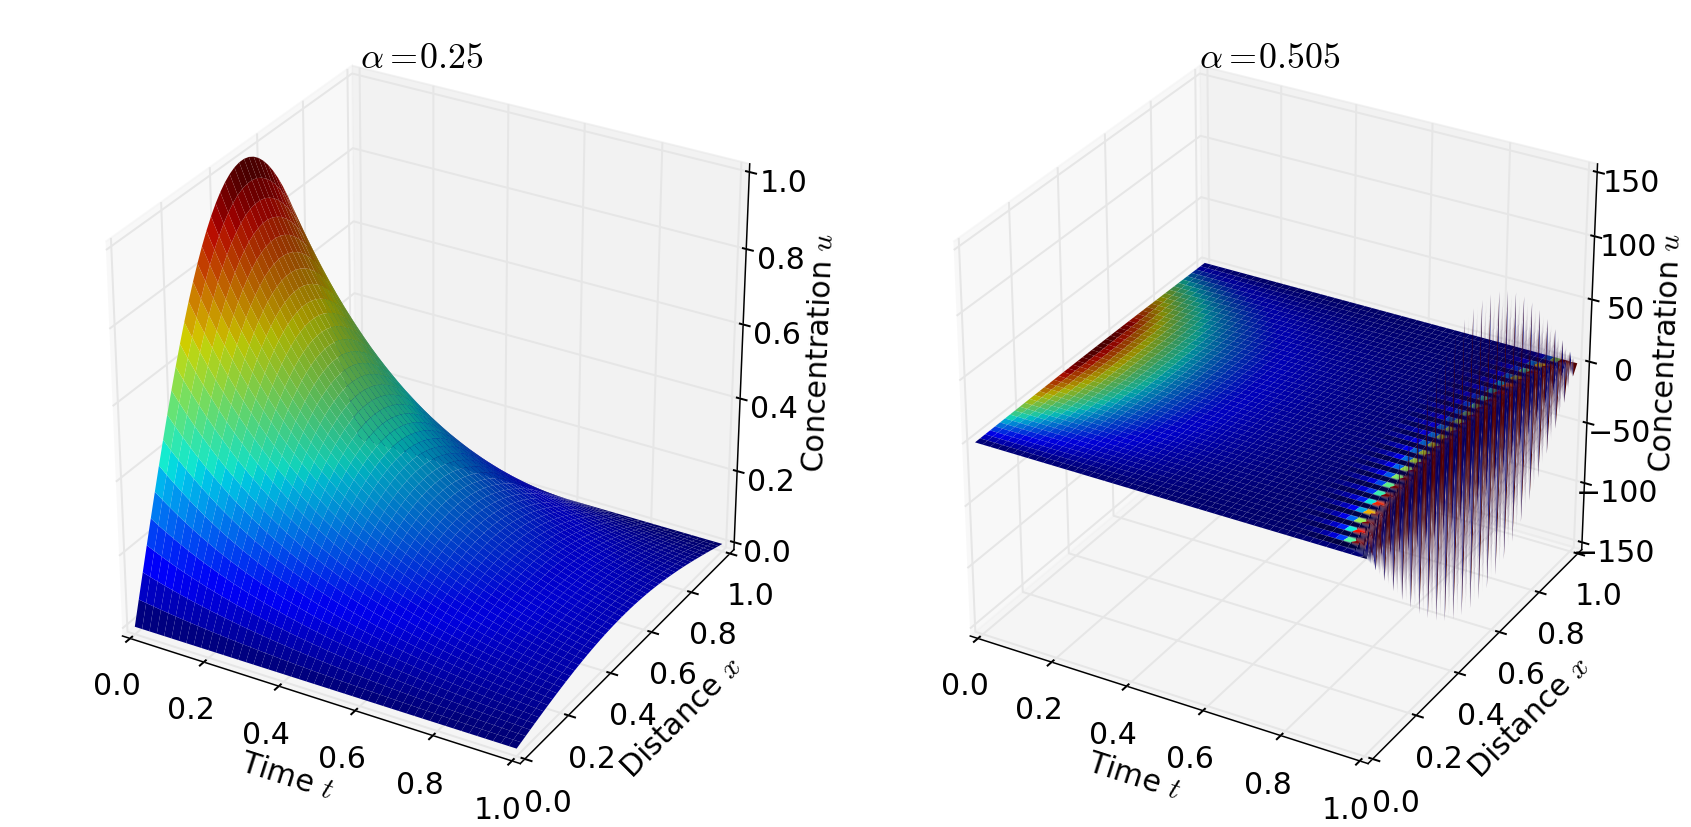

In [54]:
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

# CFL = 0.25
ax = fig.add_subplot(121, projection='3d')
u, x, t, alpha = explicitDiffusion(Nt = 2500, Nx = 50, L= 1., T = 1., D = 0.25)
T, X = meshgrid(t,x)
N = u/u.max()
ax.plot_surface(T, X, u, linewidth=0, facecolors=cm.jet(N), rstride=1, cstride=50 )
ax.set_xlabel('Time $t$')
ax.set_ylabel('Distance $x$')
ax.set_zlabel('Concentration $u$')
ax.set_title('$\\alpha = 0.25$')

ax = fig.add_subplot(122, projection='3d')
u1, x1, t1, alpha1 = explicitDiffusion(Nt = 2500, Nx = 50, L= 1., T = 1., D = 0.505)
T1, X1 = meshgrid(t1,x1)
N1 = u1/1.
ax.plot_surface(T1, X1, u1, linewidth=0, facecolors=cm.jet(N1), rstride=1, cstride=50 )
ax.set_xlabel('Time $t$')
ax.set_ylabel('Distance $x$')
ax.set_zlabel('Concentration $u$')
ax.set_title('$\\alpha = 0.505$')
# ax.set_zlim3d(0, 1)                     

plt.tight_layout() # optimises the layout

By experimenting with various values of $\alpha$, we see that the numerical solution starts to become unstable when $\alpha > 0.5$. Here's another view of the solution, this time in 2D (in the $x$-$u$ plane). In these plots, the instability takes some time to develop, but that is because I have chosen $\alpha$ to be only slightly larger than 0.5. 

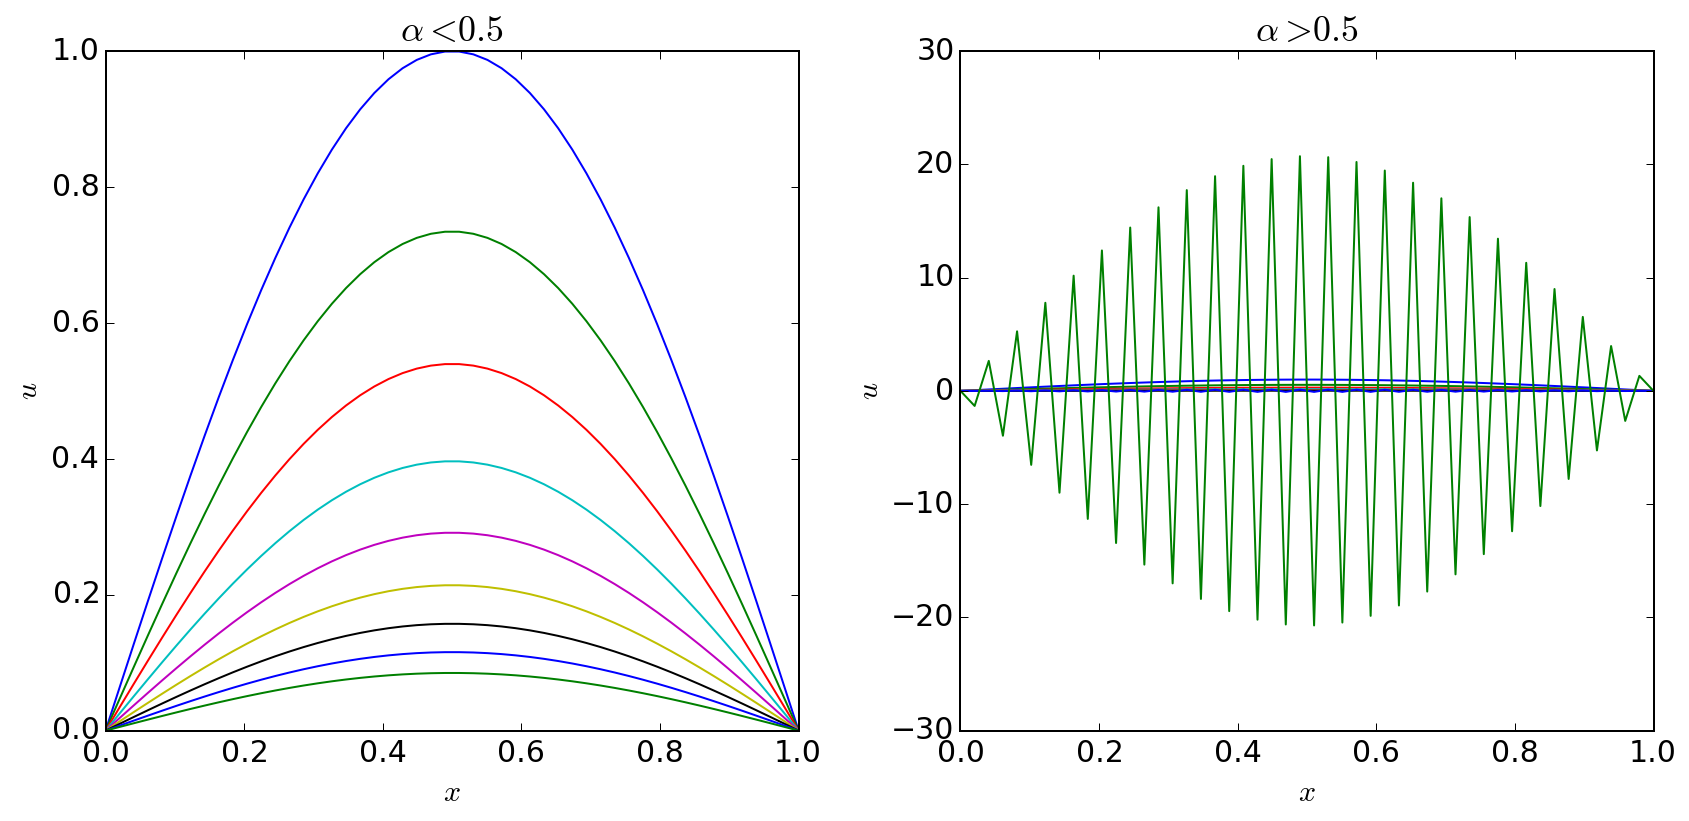

In [51]:
plt.figure(figsize=(12,6))
plt.subplot(121)
Nt = 2500
for i in range(Nt):
    if i%300== 0:
        plt.plot(x, u[:,i])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('$\\alpha < 0.5$')
        
plt.subplot(122)
for i in range(Nt):
    if i%300== 0:
        plt.plot(x1, u1[:,i])
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('$\\alpha > 0.5$')
plt.rcParams['font.size'] = 15
plt.tight_layout()

## Stability of the explicit scheme

Any single-valued and continuous function $f(x)$ can be expressed as a Fourier series. (Single-valued means that for every $x$ input into a function $f(x)$ we receive only one possible value. Technically, it is also required that $f(x)$ is periodic, but we can get around this limitation by constructing a periodic function by symmetry or some other means.) Then

$$ u(t_n,x_j) = \sum_j \hat{u}(t) \exp (ik x), $$ 

where $k$ is the wavenumber in Fourier space. Let us change the space variable to $j$ to accommodate the complex number variable $i$, and also use the discrete form of the space variable $x_j = j\Delta x$. This gives

$$ u_j^n = \hat{u}^n e^{ikj\Delta x}.$$

The explicit form of the discretised diffusion equation is 

$$ \hat{u}^{n+1} e^{ikj\Delta x} = \hat{u}^n e^{ikj\Delta x} + \alpha \left[ \hat{u}^n e^{ik(j-1)\Delta x}- 2\hat{u}^n e^{ikj\Delta x} + \hat{u}^n e^{ik(j+1)\Delta x} \right]$$

for $j = 0, 1... N_j$. The exponential terms $e^{ikj\Delta x}$ cancel out, leaving

$$ \hat{u}^{n+1} = \hat{u}^n \left[1 + \alpha \left(  e^{-ik\Delta x} - 2 + e^{ik\Delta x} \right) \right].$$ 

This cancellation tells us that we don't really have to worry about which $j$ we are analysing in the Fourier expansion, it applies equally to all the terms in the expansion. To quantify how the remaining exponential terms behave from timestep $n$ to $n+1$, we define the *growth factor*

$$ G(k) = \frac{\hat{u}^{n+1}}{\hat{u}^n} = 1 + \alpha  \left(  e^{-ik\Delta x} - 2 + e^{ik\Delta x} \right). $$

Substituting the famous Euler formula $e^{ix} = \cos(x) + i \sin(x)$ yields

$$ G(k) = 1 + \alpha\left[2\cos (k\Delta x) - 2 \right]. $$

For the growth of the Fourier mode to be stable, $\vert G(k)\vert \le 1$ for all $k$. Next we use the identity $\cos(x) = 1 - 2 \sin^2 (x/2) $, giving

$$ G(k) = 1 + \alpha\left[2 - 4\sin^2 \left(\frac{k\Delta x}{2}\right) - 2 \right]. $$

The condition for stability is specified by

$$ -1 < 1 + \alpha\left[2 - 4\sin^2 \left(\frac{k\Delta x}{2}\right) - 2 \right] < 1. $$

Rearranging the inequalities a bit

$$ -2 < -4\alpha \sin^2 \left(\frac{k\Delta x}{2}\right) < 0, $$

$$ 2 > 4\alpha \sin^2 \left(\frac{k\Delta x}{2}\right) > 0. $$

The right hand side of the inequality is trivially satisfied, since the square of sine is positive. Also, the maximum value of the sine function is 1. That leave us with the condition for stability of the explicit scheme,

$$ \alpha = \frac{D\Delta t}{(\Delta x)^2} < \frac{1}{2}.$$

With just 12 lines in the implementation (and it can be shorter than this), the explicit scheme is simple to implement. However, the disadvantages are also clear:

* The condition for stability can be very severe and will require very small time steps $\Delta t$ in general – as you can see, for $D\sim 1$ we needed 2500 time steps for a space discretisation of 50 steps. 

* Because of the above the explicit scheme can be computationally intensive. 

* The scheme is only accurate to first order due to the time derivative. 

## Solving the diffusion equation by the implicit scheme

When solving the 1-dimensional diffusion equation, the implicit scheme is an improvement on the explicit scheme in that it is more stable. In the implicit scheme, we discretise the time coordinate by backward differences,

$$ \frac{u_i^{n} - u_i^{n+1} }{\Delta t} = D \frac{u_{i-1}^{n+1} - 2u_{i}^{n+1} + u_{i+1}^{n+1}}{(\Delta x)^2}. $$

Using $\alpha = D\Delta t / (\Delta x)^2$ and rearranging gives the update equation

$$ u_i^n = -\alpha u_{i-1}^{n+1} + (1+2\alpha) u_i^{n+1}  -\alpha u_{i+1}^{n+1}. $$

Writing out a few of the equations gives

$$ u_1^n = -\alpha u_{0}^{n+1} + (1+2\alpha) u_1^{n+1}  -\alpha u_{2}^{n+1}, $$

$$ u_2^n = -\alpha u_{1}^{n+1} + (1+2\alpha) u_2^{n+1}  -\alpha u_{3}^{n+1}, $$

$$... $$

$$ u_{N_x - 2}^n = -\alpha u_{N_x - 3}^{n+1} + (1+2\alpha) u_{N_x - 2}^{n+1}  -\alpha u_{N_x -1}^{n+1}. $$

It's clear that at time $n$ we don't know what the values are at $n+1$, because we are trying to predict what the diffusion does in future. In other words, the $u_i^n$ are known to us, but not $u_i^{n+1}$. Clearly, we have a lot of unknown terms, but we can just write out a system of our $N_x - 2$ unknown equations (the boundary conditions take care of 2 of the unknown equations) in a tridiagonal form

$$ \begin{bmatrix} u_1^n \\ u_2^n \\ u_3^n \\ ... \\ u_{N_x-4}^n \\ u_{N_x-3}^n \\ u_{N_x-2}^n \end{bmatrix} =  \begin{bmatrix} 1+2\alpha && -\alpha && 0  && ... && 0 && 0 && 0 \\ -\alpha && 1+ 2\alpha && -\alpha && ... && 0 && 0 && 0 \\ 0 && -\alpha && 1+2\alpha && ... && 0 && 0 && 0 \\ ... && ... && ... && ... && ... &&... &&... \\ 0 && 0 && 0 && ... && 1+2\alpha && -\alpha && 0 \\ 0 && 0 && 0 && ... && -\alpha && 1+2\alpha && -\alpha \\ 0 && 0 && 0 && ... &&0 && -\alpha && 1+2\alpha \end{bmatrix}    \begin{bmatrix} u_1^{n+1} \\ u_2^{n+1} \\ u_3^{n+1} \\ ... \\ u_{N_x-4}^{n+1} \\ u_{N_x-3}^{n+1} \\ u_{N_x-2}^{n+1} \end{bmatrix} +  \begin{bmatrix} -\alpha u_0^{n+1} \\ 0 \\ 0 \\ ... \\ 0 \\0 \\ -\alpha u_{N_x-1}^{n+1} \end{bmatrix},$$

or in short,

$$ {\bf u}^n = {\bf M} {\bf u}^{n+1} + {\bf b}, $$

where ${\bf M}$ is a tridiagonal matrix. Note that we have to supply an additional vector ${\bf b}$ for the $u_0$ and $u_{N_x -1}$ terms which do not go into the solution matrix – these values are supplied from the boundary conditions. We can then solve for the future terms ${\bf u}^{n+1}$ by matrix inversion

$$ {\bf u}^{n+1} = {\bf M}^{-1} ( {\bf u}^n - {\bf b} ). $$

In the code I did not treat the boundary conditions since they are both zero. But you could treat this if you want within the time loop of the code. 

In [29]:
def implicitDiffusion(Nt, Nx, L, T, D):

    dt = L/Nt
    dx = T/Nx
    alpha = D*dt/(dx*dx) # the CFL number

    x = linspace(0, L, Nx)
    t = linspace(0, T, Nt)
    u = zeros((Nx, Nt))

    # Initial condition - the concentration profile when t = 0 
    u[:,0] = sin(pi*x)

    # Boundary condition: u[-1] refers to the *last* element of u
    u[0,:] = 0
    u[-1,:] = 0

    aa = -alpha*ones(Nx-3)
    bb = (1+2*alpha)*ones(Nx-2)
    cc = -alpha*ones(Nx-3)
    M = diag(aa, -1) + diag(bb,0) + diag(cc,1)
    
    for k in range(1,Nt):
        u[1:-1, k] = linalg.solve(M, u[1:-1, k-1])
    
    return u, x, t, alpha

To contrast with the explicit method I have input the exact parameters for the CFL number $\alpha$ and discretisation sizes $\Delta t, \Delta x$ into the implicit solver. 

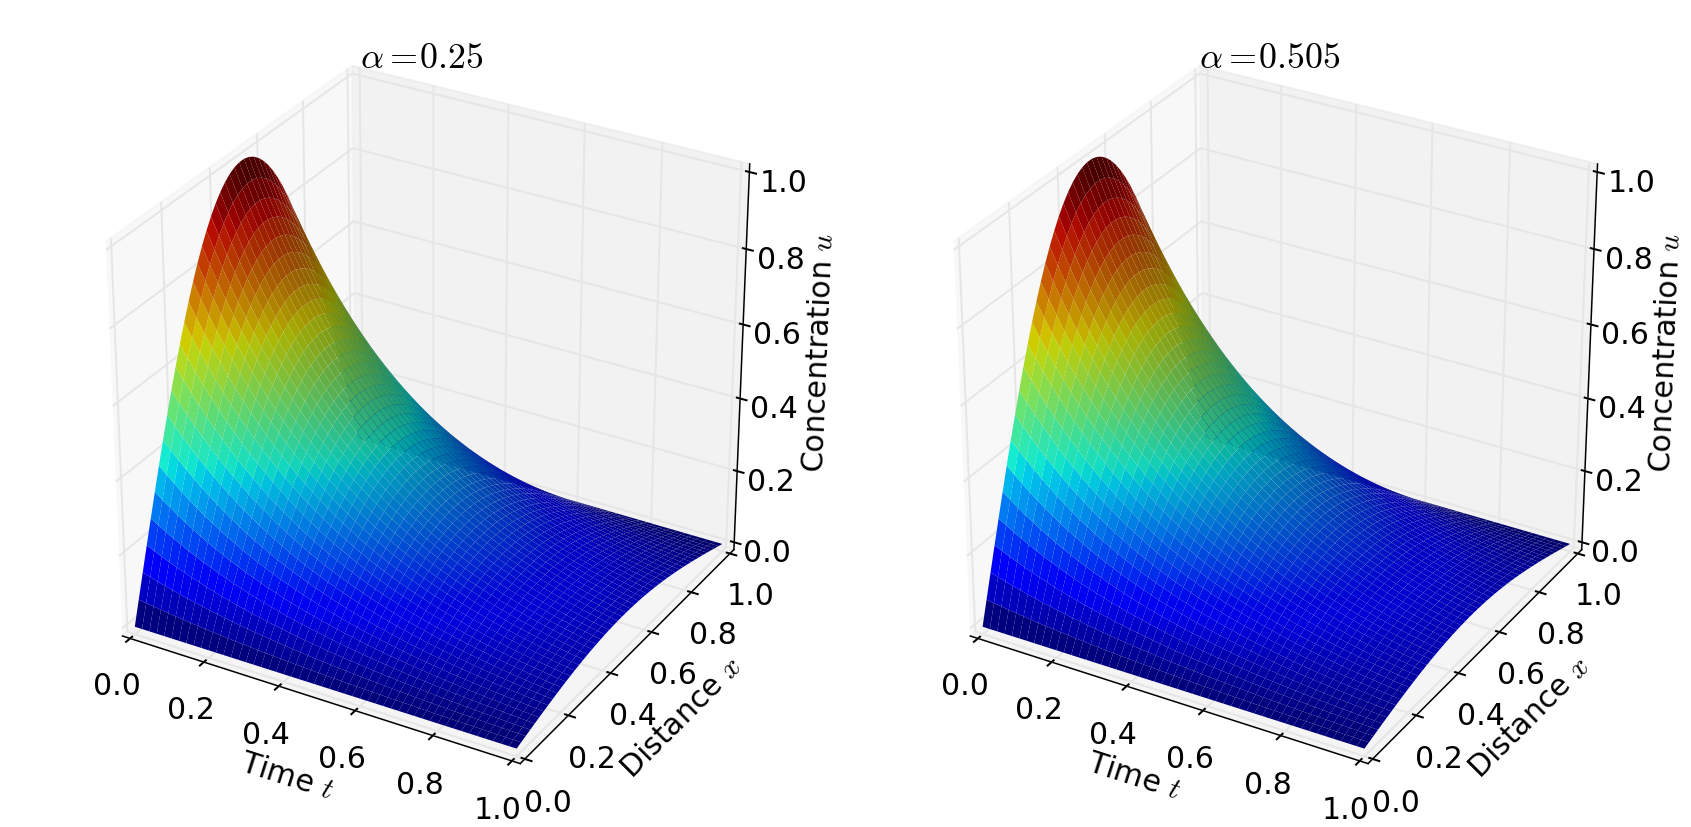

In [53]:
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

ax = fig.add_subplot(121, projection='3d')
ui, xi, ti, alphai = implicitDiffusion(Nt = 2500, Nx = 50, L= 1., T = 1., D = 0.25)
Ti, Xi = meshgrid(ti,xi)
N = ui/ui.max()
ax.plot_surface(Ti, Xi, ui, linewidth=0, facecolors=cm.jet(N), rstride=1, cstride=50 )
ax.set_xlabel('Time $t$')
ax.set_ylabel('Distance $x$')
ax.set_zlabel('Concentration $u$')
ax.set_title('$\\alpha = 0.25$')

ax = fig.add_subplot(122, projection='3d')
ui1, xi1, ti1, alphai1 = implicitDiffusion(Nt = 2500, Nx = 50, L= 1., T = 1., D = 0.25)
Ti1, Xi1 = meshgrid(ti1,xi1)
N = ui1/ui1.max()
ax.plot_surface(Ti1, Xi1, ui1, linewidth=0, facecolors=cm.jet(N), rstride=1, cstride=50 )
ax.set_xlabel('Time $t$')
ax.set_ylabel('Distance $x$')
ax.set_zlabel('Concentration $u$')
ax.set_title('$\\alpha = 0.505$')
plt.tight_layout()

As you can see, the implicit method is stable for both CFL numbers. This alone can't tell us how stable the implicit scheme is, or under what conditions it fails, though, so we have to use the stability analysis again.

## Stability analysis of the implicit scheme

The stability analysis is performed by substituting the Fourier modes $ u_j^n = \hat{u}^n e^{ikj\Delta x}$ into the discretisation equation, 

$$ \hat{u}^{n+1} e^{ikj\Delta x} - \hat{u}^{n} e^{ikj\Delta x} =  \alpha \left[ \hat{u}^{n+1} e^{ik(j-1)\Delta x}- 2\hat{u}^{n+1} e^{ikj\Delta x} + \hat{u}^{n+1} e^{ik(j+1)\Delta x} \right],$$

$$ \hat{u}^n  = \hat{u}^{n+1} \left[ -\alpha e^{-ik\Delta x} + (1-2\alpha) -\alpha e^{ik\Delta x} \right]. $$

The growth factor $G(k) = \hat{u}^{n+1} / \hat{u}^n$ is then

$$ G(k) = \frac{1}{1 - \alpha[2\cos(k\Delta x) - 2]}, $$

$$ G(k) = \frac{1}{1 + 4\alpha\sin^2(k\Delta x)}. $$

Here we have used the same trigonometric identity as in the explicit scheme. It is clear that since $\sin^2(x)$ is positive, then the denominator is always more than 1. Therefore,

$$ \vert G(k) \vert \le 1. $$

In other words, the **implicit scheme is unconditionally stable** – it is stable for any choice of the grid spacings $\Delta x$ and $\Delta t$. There are a few downsides of the implicit scheme, however:

* It is slow, since you have to invert a matrix at each time step. This usually means Gaussian elimination and back-substitution. However, there are algorithms that speed up the solution of the coefficient matrix ${\bf M}$, e.g. L-U decomposition. 

* It uses more code, especially if you want to implement your own equation solver during the inversion step. 

* It is accurate to only first order in $x$ (i.e. no more accurate than the explicit scheme).